<a href="https://colab.research.google.com/github/nv-hiep/galaxy_classifier/blob/master/Galaxy_Classifier_Norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Galaxy Classification**

Galaxy Classification with Python/R, colab.

Data: https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge/data


The Galaxy Zoo 2 decision tree: https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge/overview/the-galaxy-zoo-decision-tree

**Data Description**

1. images_training: JPG images of 61578 galaxies. Files are named according to their GalaxyId.

2. solutions_training: Probability distributions for the classifications for each of the training images.

3. images_test: JPG images of 79975 galaxies. Files are name according to their GalaxyId. You will provide probabilities for each of these images. 

4. all_ones_benchmark: Sample submission file corresponding to the All Ones Benchmark

5. all_zeros_benchmark: Sample submission file corresponding to the All Zeros Benchmark

6. central_pixel_benchmark: Simple benchmark that clusters training galaxies according to the color in the center of the image and then assigns the associated probability values to like-colored images in the test set.

The first column in each solution is labeled GalaxyID; this is a randomly-generated ID that only allows you to match the probability distributions with the images.

The next 37 columns are all floating point numbers between 0 and 1 inclusive. These represent the morphology (or shape) of the galaxy in 37 different categories as identified by crowdsourced volunteer classifications as part of the Galaxy Zoo 2 project. These morphologies are related to probabilities for each category; a high number (close to 1) indicates that many users identified this morphology category for the galaxy with a high level of confidence. Low numbers for a category (close to 0) indicate the feature is likely not present. 

# Import Libraries

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= '2.0'

if not tf.config.list_physical_devices('GPU'):
    print('No GPU was detected. LSTMs and CNNs can be very slow without a GPU.')
    if IS_COLAB:
        print('Go to Runtime > Change runtime and select a GPU hardware accelerator.')

# Common imports
import os
import random
import shutil
import itertools
import glob
import string
import pickle
import json
import re

from bson import json_util

import numpy as np
import matplotlib.image as mpimg
import pandas as pd

from tqdm import tqdm
from time import time
from PIL import Image
from datetime import date


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)

In [2]:
print(tf.__version__)
tf.test.gpu_device_name()

2.6.0


'/device:GPU:0'

In [ ]:
# from urllib.request import urlopen
# from io import BytesIO
# from zipfile import ZipFile

In [3]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Thu Oct 14 06:32:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    60W / 149W |    121MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Connect and authorize google drive

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


**Project "Galaxy Classifier" directory in google drive:**

In [ ]:
# %cd /content/gdrive/My Drive/
%cd /content/gdrive/My Drive/Colab Notebooks/galaxy_classifier/
!ls

**Data for "Galaxy Classifier" directory in google drive:**

In [8]:
%cd /content/gdrive/My Drive/data/galaxy_data/
!ls

/content/gdrive/My Drive/data/galaxy_data
plots.png  test		    train_hist_dict_rgb  training_solutions_rev1.csv
preview    train_hist_dict  training		 validation


# Data path

In [9]:
current_dir = os.getcwd()
print(current_dir)

data_path    = '/content/gdrive/My Drive/data/galaxy_data'
training_dir = os.path.join(data_path, 'training')
valid_dir    = os.path.join(data_path, 'validation')

/content/gdrive/My Drive/data/galaxy_data


In [10]:
# Get the total images in the training and validation dataset, this should be around 8619 images for training, and 2875 for validation.
total_train = 0
for c in ['elliptical', 'lenticular', 'spiral']:
  total_train += len(os.listdir(os.path.join(training_dir, c)))
print('Total train:', total_train)

total_validation = 0
for c in ['elliptical', 'lenticular', 'spiral']:
  total_validation += len(os.listdir(os.path.join(valid_dir, c)))
print('Total validation:', total_validation)

Total train: 8619
Total validation: 2875


# Data Augmentation

In [12]:
dir_augmented_data = os.path.join(data_path, 'preview')
try:
    ## if the preview folder does not exist, create
    os.mkdir(dir_augmented_data)
except:
    ## if the preview folder exists, then remove
    ## the contents (pictures) in the folder
    for item in os.listdir(dir_augmented_data):
        os.remove(dir_augmented_data + "/" + item)


# Resize the images to (x, x) pixels
target_size = (150, 150)

# Set the batch size.
batch_size = 32

# Color channels
color_channels = 3


# Create the data generator for both sets, but now with image augmentation,
# where random operations are made on images like random shifts or rotationson each batch,
# stil do the rescale and set the target size.

# datagen for training set
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                    rescale            = 1./255.,
                    rotation_range     = 25,
                    width_shift_range  = 0.15,
                    height_shift_range = 0.15,
                    horizontal_flip    = True,
                    zoom_range         = 0.2)


train_generator = train_datagen.flow_from_directory(training_dir,
                                                    target_size = target_size,
                                                    batch_size  = batch_size,
                                                    shuffle     = True,
                                                    class_mode  = 'categorical')


# datagen for validation set
validation_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)
validation_generator = validation_datagen.flow_from_directory(valid_dir,
                                                         target_size = target_size,
                                                         batch_size  = batch_size,
                                                         shuffle     = False,
                                                         class_mode  = 'categorical')

allclasses = train_generator.class_indices    
print('ALL classes:')
print(allclasses)

Found 8619 images belonging to 3 classes.
Found 2875 images belonging to 3 classes.
ALL classes:
{'elliptical': 0, 'lenticular': 1, 'spiral': 2}


In [ ]:
# To see what's going on this data augmentation, run the following
if False:
  i = 0
  for batch in train_datagen.flow_from_directory(training_dir,
      target_size = target_size, batch_size  = batch_size,
      save_to_dir = dir_augmented_data, save_prefix = 'pic', save_format = 'png',
      color_mode = 'grayscale', shuffle = True, class_mode  = 'categorical'):

      i += 1
      if i > 5: # save 20 images
          break  # otherwise the generator would loop indefinitely

# **The model**

In [15]:
# Create the model, using a sequence of convolution and pooling layers,
# followed by a dropout layer, a fully connected layer, and the last softmax layer.

# Xem: https://forum.machinelearningcoban.com/t/tutorial-tinh-so-luong-parameters-trong-convolutional-neural-network/3638


model = tf.keras.models.Sequential([
    # first convolution layer, input is an 64x64 image x3 colors
    # 64 filters, with a size of (3x3) for each filter (each filter has 3x3 = 9 weights)
    # e.g: input = 28x28 pixels
    #      kernel filter = (3,3)
    #      No. of filters: 32
    #     -> Output of Conv2D layer: (28 x 28 x 32)
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',
                           input_shape=(target_size[0],target_size[1], color_channels)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    # second convolution layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # third convolution layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # fourth convolution layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # flatten the image pixels
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    
    # 512 neuron fully connected hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()  # inspect model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [16]:
# Compile the model to use a categorical cross entropy loss function, and a adam optmizier.
from tensorflow.keras import losses
loss_fcn = tf.keras.losses.CategoricalCrossentropy(from_logits=False,
                                              label_smoothing=0,
                                              reduction="auto",
                                              name="categorical_crossentropy"
                                            )
model.compile(loss=loss_fcn,
              optimizer='adam',
              metrics=['accuracy'])

# **Train the model**

In [19]:
# Use callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                              mode = 'max',
                                              patience=10,
                                              restore_best_weights=False
                                            )

In [20]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=5,
                                                 min_lr=0.001
                                                )

In [21]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [23]:
EPOCHS = 100

history = model.fit(train_generator,
                    epochs=EPOCHS,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator)//batch_size,
                    # callbacks=[early_stop], # use callbacks
                    verbose=True)

Epoch 1/100
269/269 [==============================] - 4196s 15s/step - loss: 0.7926 - accuracy: 0.5675 - val_loss: 0.8586 - val_accuracy: 0.4375
Epoch 2/100
269/269 [==============================] - 90s 333ms/step - loss: 0.6371 - accuracy: 0.6597 - val_loss: 0.5055 - val_accuracy: 0.8750
Epoch 3/100
269/269 [==============================] - 89s 332ms/step - loss: 0.5748 - accuracy: 0.6947 - val_loss: 0.4018 - val_accuracy: 0.9688
Epoch 4/100
269/269 [==============================] - 89s 331ms/step - loss: 0.5389 - accuracy: 0.7228 - val_loss: 0.7270 - val_accuracy: 0.6250
Epoch 5/100
269/269 [==============================] - 90s 333ms/step - loss: 0.5083 - accuracy: 0.7440 - val_loss: 0.2347 - val_accuracy: 1.0000
Epoch 6/100
269/269 [==============================] - 89s 332ms/step - loss: 0.4915 - accuracy: 0.7615 - val_loss: 0.4113 - val_accuracy: 0.9219
Epoch 7/100
269/269 [==============================] - 89s 331ms/step - loss: 0.4762 - accuracy: 0.7683 - val_loss: 0.6596 -

In [24]:
print(data_path + '/train_hist_dict.pkl')
with open(data_path + '/train_hist_dict.pkl', 'wb') as file_hist:
        pickle.dump(history.history, file_hist)

/content/gdrive/My Drive/data/galaxy_data/train_hist_dict.pkl


**Finish training -> plot graphs**

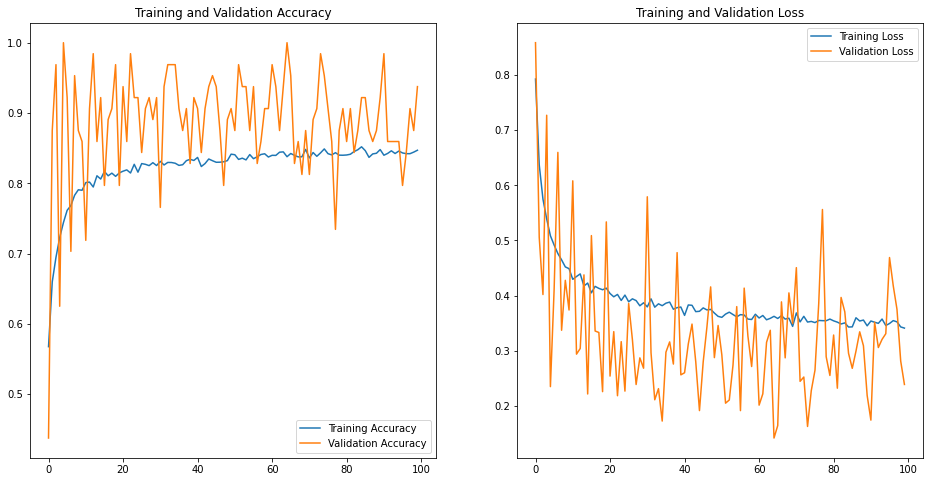

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # range for the number of epochs

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(data_path + '/plots.png')
plt.show()

# **Save the trained model**

In [26]:
model.save(data_path + '/galaxy_convnet_rgb.h5')